In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
import glob
import os

# POLOCM2 BASELINE acceptance rate

In [70]:
import os
import glob
import pandas as pd

# Load and clean data
folder_path = "../../output/p2/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df.columns = df.columns.str.strip()
df = df[df['remark'] != 'Timeout']
df['len%'] = df['len%'].astype(float) * 100.0

# Total entries per domain (including Timeout) for solved ratio
total_counts = (
    pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
    .assign(domain=lambda d: d['domain'].str.strip())  # ensure no trailing spaces
    .groupby('domain')
    .size()
    .rename("total")
)

# Solved entries (excluding Timeout)
solved_stats = (
    df.groupby('domain')
    .agg(
        solved=('domain', 'count'),
        mean_valid_acc=('acceptance_rate', 'mean'),
        mean_invalid_acc=('invalid_acceptance_rate', 'mean'),
        mean_acc=('accuracy', 'mean'),
        mean_err=('error_rate', 'mean'),
    )
)

# Merge total counts to compute solved %
solved_stats = solved_stats.merge(total_counts, left_index=True, right_index=True)
solved_stats['solved_ratio'] = solved_stats['solved'] / solved_stats['total']

# Reorder columns
solved_stats = solved_stats[
    ['solved_ratio', 'mean_valid_acc', 'mean_invalid_acc', 'mean_acc', 'mean_err']
].sort_values(by='solved_ratio', ascending=False)

solved_stats['solved_ratio'] *= 100

# Format all float columns to 2 decimal places
solved_stats = solved_stats.round(2)

display(solved_stats)
for domain, row in solved_stats.iterrows():
    values = ' & '.join(f"{v:.2f}" for v in row.values)
    print(f"{domain}: &{values}")


,solved_ratio,mean_valid_acc,mean_invalid_acc,mean_acc,mean_err
domain,,,,,
spanner,99.73,0.40,0.00,0.83,0.04
miconic,98.78,0.40,0.29,0.76,0.06
sokoban,95.92,0.69,0.42,0.87,0.01
childsnack,91.41,0.23,0.09,0.89,0.03
ferry,84.80,0.38,0.08,0.74,0.10
blocksworld,83.86,0.58,0.19,0.87,0.05
transport,80.34,0.24,0.06,0.75,0.08
satellite,66.00,0.04,0.08,0.79,0.07
floortile,64.77,0.13,0.06,0.82,0.06


spanner: &99.73 & 0.40 & 0.00 & 0.83 & 0.04
miconic: &98.78 & 0.40 & 0.29 & 0.76 & 0.06
sokoban: &95.92 & 0.69 & 0.42 & 0.87 & 0.01
childsnack: &91.41 & 0.23 & 0.09 & 0.89 & 0.03
ferry: &84.80 & 0.38 & 0.08 & 0.74 & 0.10
blocksworld: &83.86 & 0.58 & 0.19 & 0.87 & 0.05
transport: &80.34 & 0.24 & 0.06 & 0.75 & 0.08
satellite: &66.00 & 0.04 & 0.08 & 0.79 & 0.07
floortile: &64.77 & 0.13 & 0.06 & 0.82 & 0.06


In [65]:
import os
import glob
import pandas as pd

# Load and clean data
folder_path = "../../output/p2/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df_full = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df_full.columns = df_full.columns.str.strip()
df_full['domain'] = df_full['domain'].str.strip()
df_full['len%'] = df_full['len%'].astype(float) * 100.0

# Add flex level
def classify_flex(dod):
    if 0.1 <= dod <= 0.3: return 'Low'
    if 0.4 <= dod <= 0.6: return 'Medium'
    if 0.7 <= dod <= 0.9: return 'High'
    return 'Other'

df_full['flex'] = df_full['dod'].apply(classify_flex)
df_full = df_full[df_full['flex'] != 'Other']


# Total counts (incl. timeout), grouped by domain + flex
total_counts = (
    df_full.groupby(['domain', 'flex']).size().rename("total")
)

# Solved only (exclude Timeout)
df_solved = df_full[df_full['remark'] != 'Timeout']

# Solved stats per domain + flex
solved_stats = (
    df_solved.groupby(['domain', 'flex'])
    .agg(
        solved=('domain', 'count'),
        mean_valid_acc=('acceptance_rate', 'mean'),
        p25_valid_acc=('acceptance_rate', lambda x: x.quantile(0.25)),
        p75_valid_acc=('acceptance_rate', lambda x: x.quantile(0.75)),

        mean_invalid_acc=('invalid_acceptance_rate', 'mean'),
        p25_invalid_acc=('invalid_acceptance_rate', lambda x: x.quantile(0.25)),
        p75_invalid_acc=('invalid_acceptance_rate', lambda x: x.quantile(0.75)),

        mean_acc=('accuracy', 'mean'),
        p25_acc=('accuracy', lambda x: x.quantile(0.25)),
        p75_acc=('accuracy', lambda x: x.quantile(0.75)),

        mean_err=('error_rate', 'mean'),
        p25_err=('error_rate', lambda x: x.quantile(0.25)),
        p75_err=('error_rate', lambda x: x.quantile(0.75)),
    )
)

# Merge to get total and calculate solved ratio
solved_stats = solved_stats.merge(total_counts, left_index=True, right_index=True)
solved_stats['solved_ratio'] = solved_stats['solved'] / solved_stats['total']

# Reorder
solved_stats = solved_stats[
    [
        'solved_ratio',
        'mean_valid_acc', 'p25_valid_acc', 'p75_valid_acc',
        'mean_invalid_acc', 'p25_invalid_acc', 'p75_invalid_acc',
        'mean_acc', 'p25_acc', 'p75_acc',
        'mean_err', 'p25_err', 'p75_err'
    ]
].sort_values(by=['domain', 'solved_ratio'], ascending=[True, False])


solved_stats['solved_ratio'] *= 100

# Format all float columns to 2 decimal places
solved_stats = solved_stats.round(2)

display(solved_stats)

solved_ratio  mean_valid_acc  p25_valid_acc  \
domain      flex                                                  
blocksworld Low           100.00            0.68           0.06   
            Medium         87.82            0.57           0.05   
            High           73.79            0.49           0.04   
childsnack  Low           100.00            0.43           0.03   
            High           91.50            0.09           0.01   
            Medium         90.16            0.19           0.02   
ferry       Low           100.00            0.45           0.02   
            Medium         87.16            0.28           0.00   
            High           75.45            0.40           0.15   
floortile   Low            83.67            0.22           0.05   
            Medium         60.63            0.07           0.00   
            High           57.27            0.07           0.00   
miconic     High          100.00            0.22           0.04   
            Low           100.00            0.66           0.19   
            Medium         99.55            0.40           0.07   
satellite   Low            85.56            0.09           0.00   
            Medium         61.56            0.01           0.00   
            High           58.44            0.02           0.00   
sokoban     Low           100.00            0.75           0.46   
            Medium         99.32            0.69           0.44   
            High           96.37            0.66           0.44   
spanner     High          100.00            0.23           0.00   
            Low           100.00            0.64           0.04   
            Medium        100.00            0.36           0.00   
transport   Low            98.88            0.46           0.00   
            Medium         79.42            0.09           0.00   
            High           70.69            0.13           0.00   

                    p75_valid_acc  mean_invalid_acc  p25_invalid_acc  \
domain      flex                                                       
blocksworld Low              1.00              0.12             0.05   
            Medium           1.00              0.18             0.05   
            High             1.00              0.25             0.13   
childsnack  Low              1.00              0.09             0.04   
            High             0.07              0.08             0.00   
            Medium           0.15              0.10             0.00   
ferry       Low              1.00              0.05             0.00   
            Medium           0.52              0.07             0.00   
            High             0.52              0.12             0.05   
floortile   Low              0.27              0.05             0.00   
            Medium           0.11              0.06             0.00   
            High             0.11              0.07             0.00   
miconic     High             0.22              0.26             0.12   
            Low              0.99              0.31             0.18   
            Medium           0.96              0.30             0.13   
satellite   Low              0.03              0.07             0.00   
            Medium           0.02              0.05             0.00   
            High             0.02              0.12             0.00   
sokoban     Low              1.00              0.42             0.39   
            Medium           1.00              0.40             0.39   
            High             1.00              0.44             0.39   
spanner     High             0.27              0.00             0.00   
            Low              1.00              0.00             0.00   
            Medium           1.00              0.00             0.00   
transport   Low              1.00              0.09             0.00   
            Medium           0.02              0.02             0.00   
            High             0.07              0.05         

In [34]:


# Read and clean
folder_path = "../../output/p2/"
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df = df[df['remark'] != 'Timeout']
df.columns = df.columns.str.strip()
df['len%'] = df['len%'].astype(float) * 100.0


plt.rcParams.update({
    "font.size": 14,        # base font size
    "axes.titlesize": 16,   # subplot titles
    "axes.labelsize": 16,   # axis labels
    "xtick.labelsize": 14,  # x-tick labels
    "ytick.labelsize": 14,  # y-tick labels
    "legend.fontsize": 14   # legend text
})

plt.rcParams.update({"font.size": 14, "axes.titlesize": 18})

sns.set_context("paper", font_scale=1.5)
# 2) optional seaborn theme
sns.set_style("whitegrid")



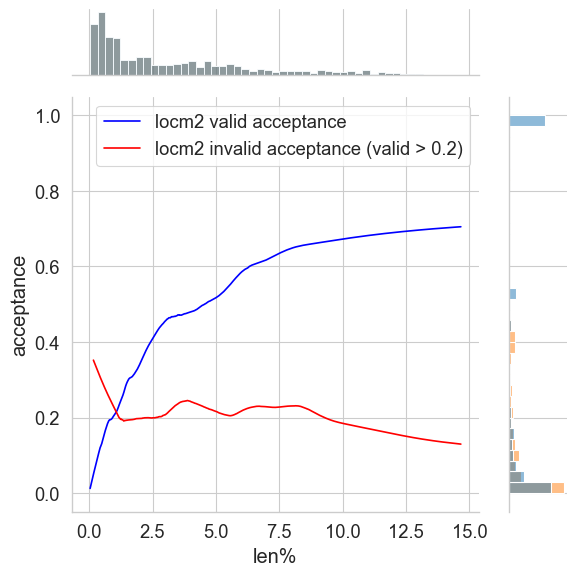

In [35]:
df_by_len = df.sort_values(by='len%')
# Apply LOWESS to full valid_exe
valid_smoothed = lowess(df_by_len['acceptance_rate'], df_by_len['len%'], frac=0.3)
filtered_df = df_by_len[df_by_len['acceptance_rate'] > 0.3]
invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['len%'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['len%'], value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
                  var_name='type', value_name='acceptance')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='len%', y='acceptance', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], label='locm2 valid acceptance', color='blue')
plt.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], label='locm2 invalid acceptance (valid > 0.2)', color='red')



plt.legend()
plt.tight_layout()
plt.show()

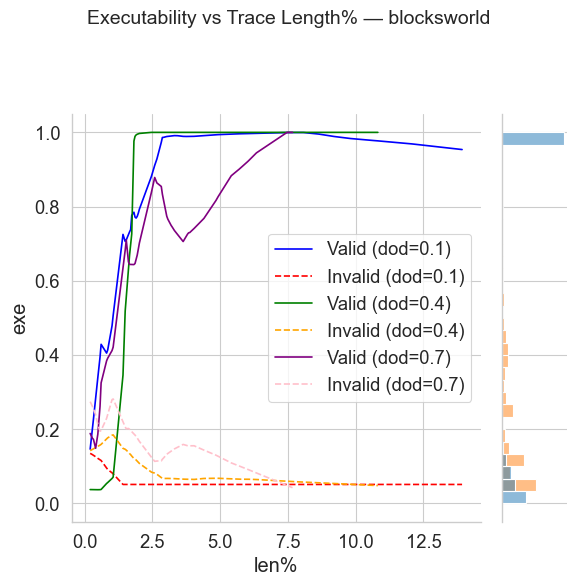

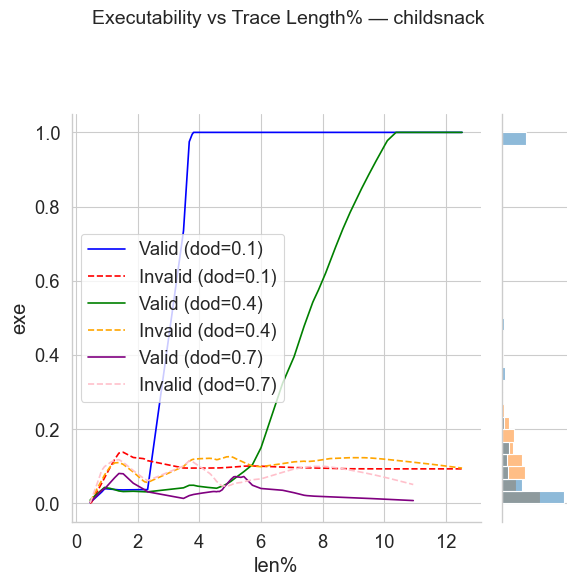

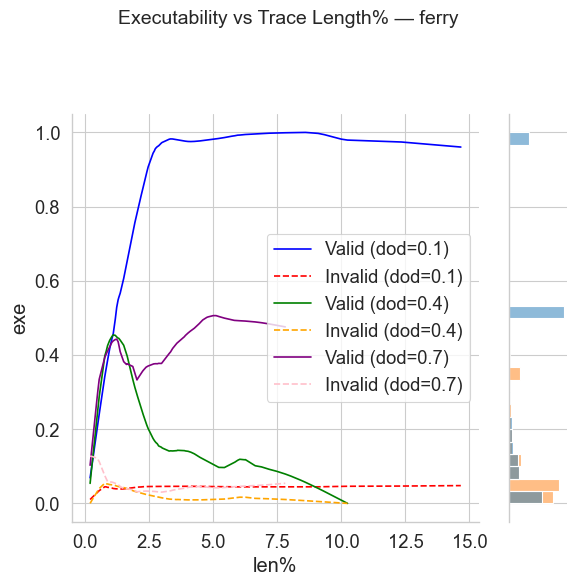

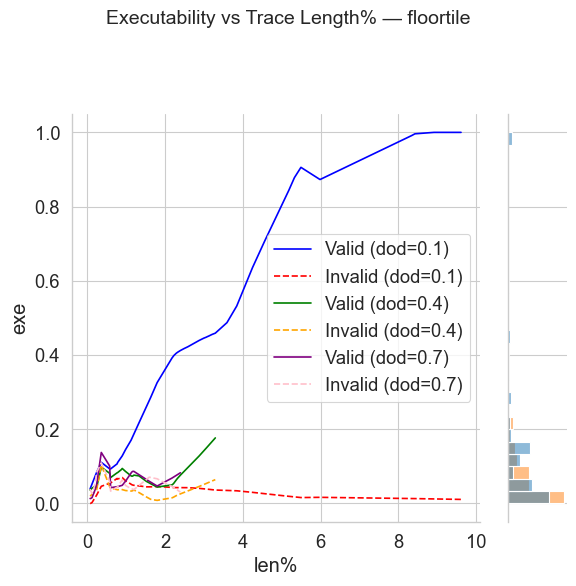

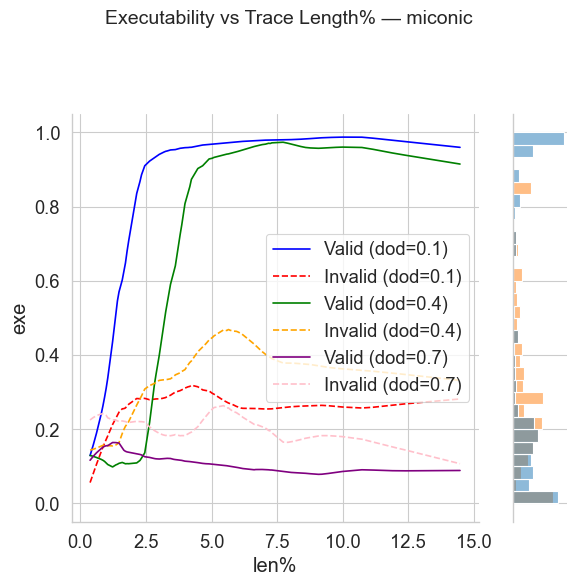

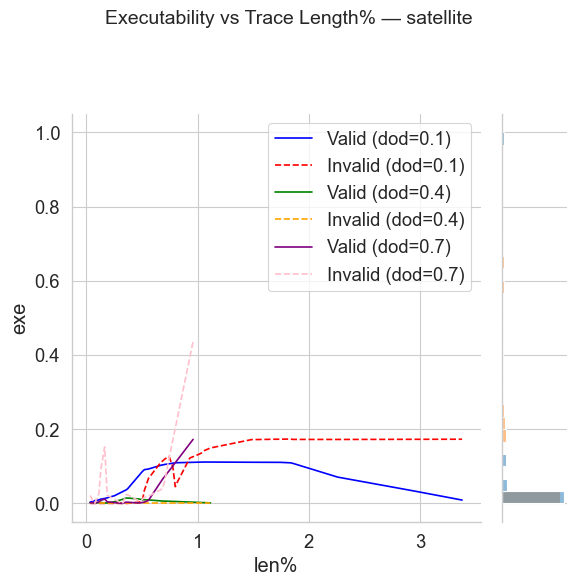

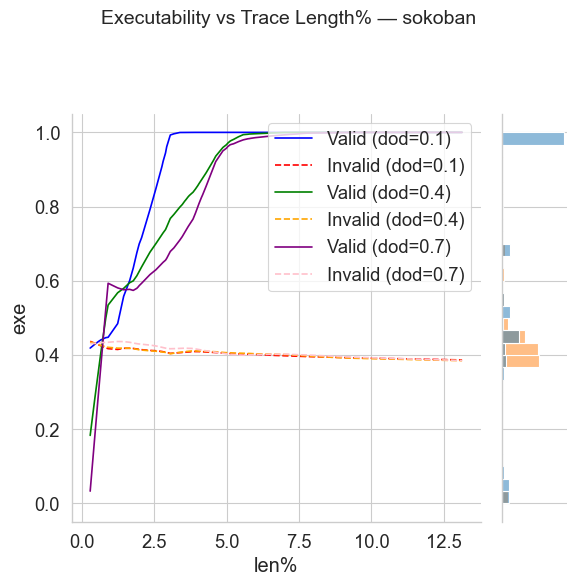

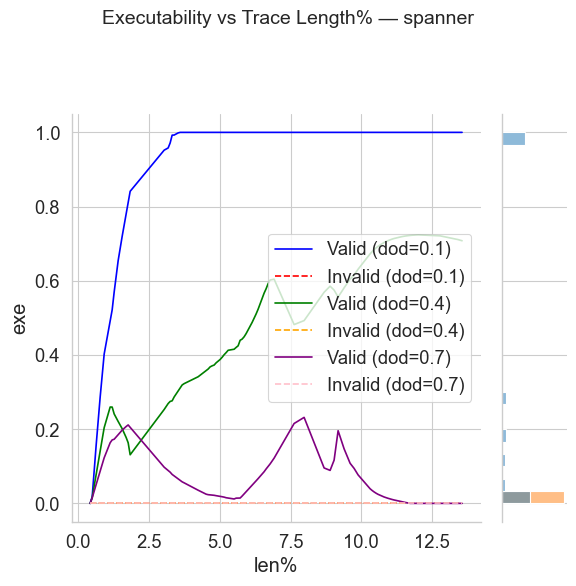

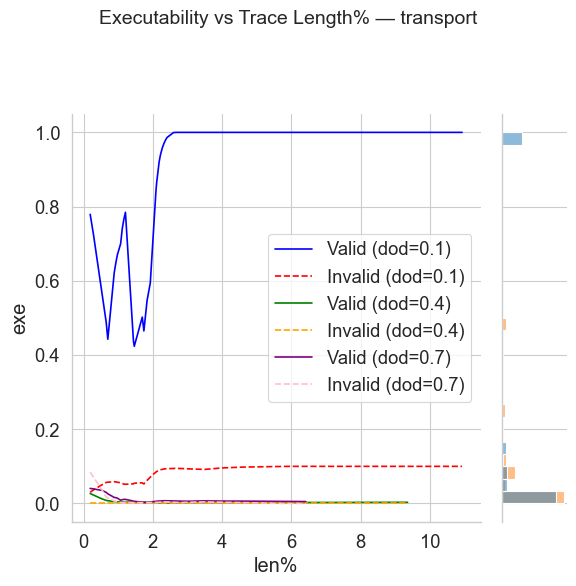

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
import pandas as pd
import numpy as np

flexs = [0.1, 0.4, 0.7]
flex_colors = {0.1: ('blue', 'red'), 0.4: ('green', 'orange'), 0.7: ('purple', 'pink')}

domains = df['domain'].unique()

for domain in domains:
    # Prepare the plot base using all data in this domain
    domain_df = df_by_len[df_by_len['domain'] == domain].copy()
    
    # Melt only the domain_df for the histograms (covering all flexs)
    df_long = pd.melt(
        domain_df,
        id_vars=['len%'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Seaborn jointplot (just once per domain)
    g = sns.jointplot(
        data=df_long,
        x='len%', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False, stat='density', bins=30)
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines per flex level
    for flex in flexs:
        sub_df = domain_df[domain_df['dod'] == flex]


        valid_smoothed = lowess(sub_df['acceptance_rate'], sub_df['len%'], frac=0.3)
        # filtered_df = sub_df[sub_df['acceptance_rate'] > 0.3]
        invalid_smoothed = lowess(sub_df['invalid_acceptance_rate'], sub_df['len%'], frac=0.3)

        valid_smoothed[:, 1] = np.clip(valid_smoothed[:, 1], 0, 1)
        invalid_smoothed[:, 1] = np.clip(invalid_smoothed[:, 1], 0, 1)

        color = flex_colors[flex]
        g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1],
                        label=f'Valid (dod={flex})', color=color[0], linestyle='-')
        g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1],
                        label=f'Invalid (dod={flex})', color=color[1], linestyle='--')

    g.ax_joint.legend()
    g.fig.suptitle(f"Executability vs Trace Length% — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)
    plt.show()


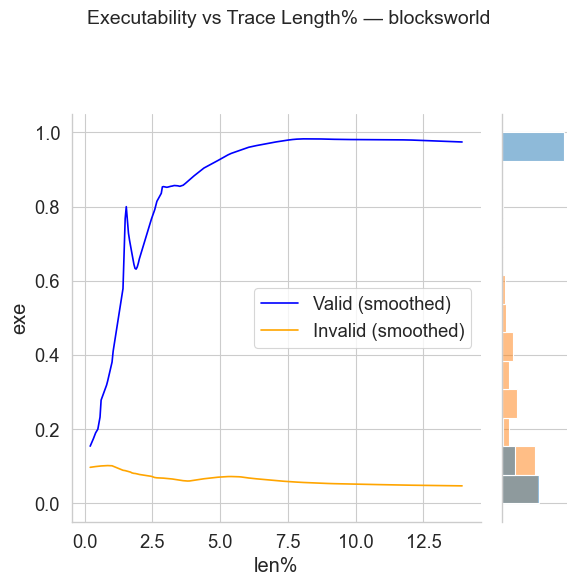

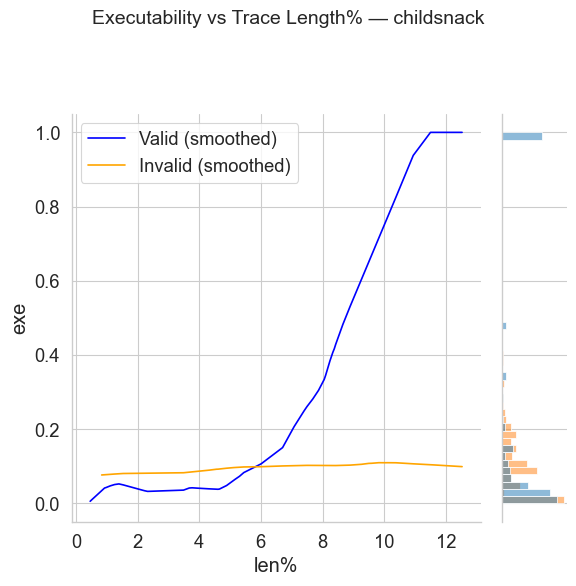

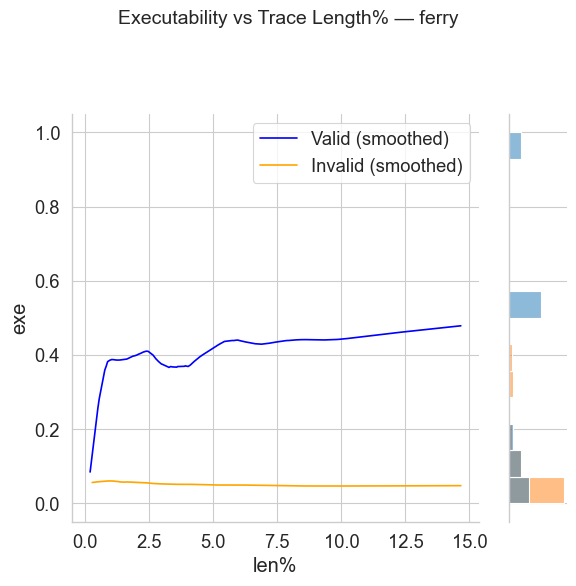

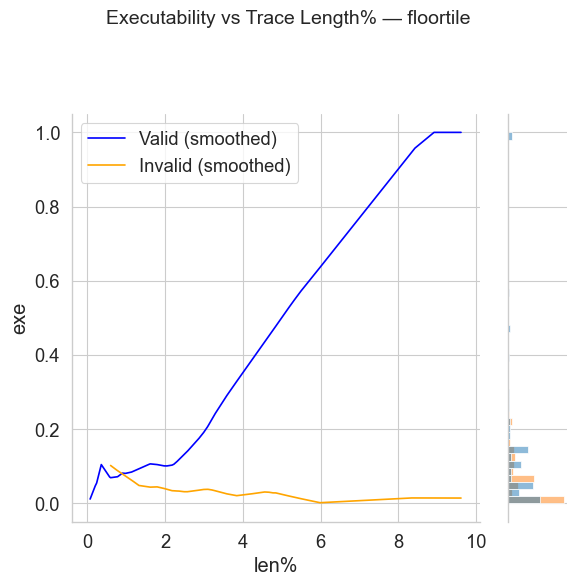

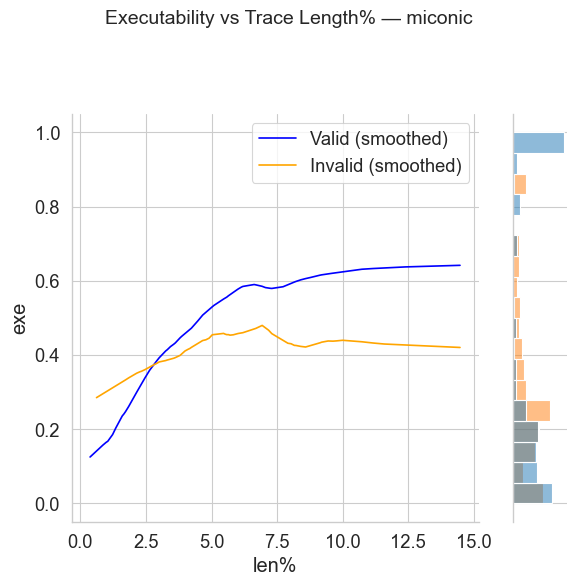

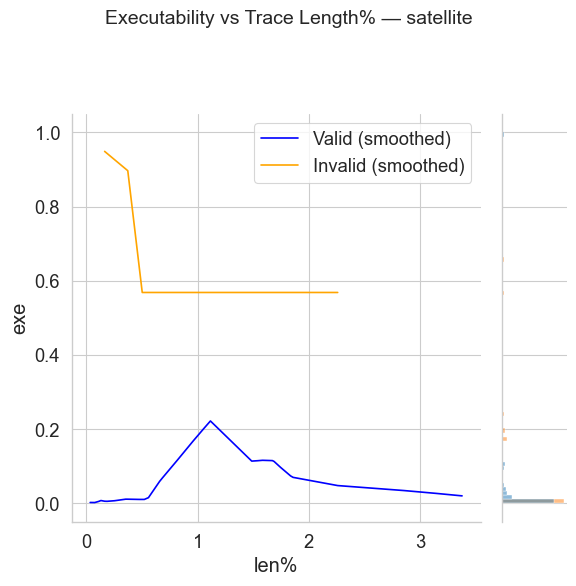

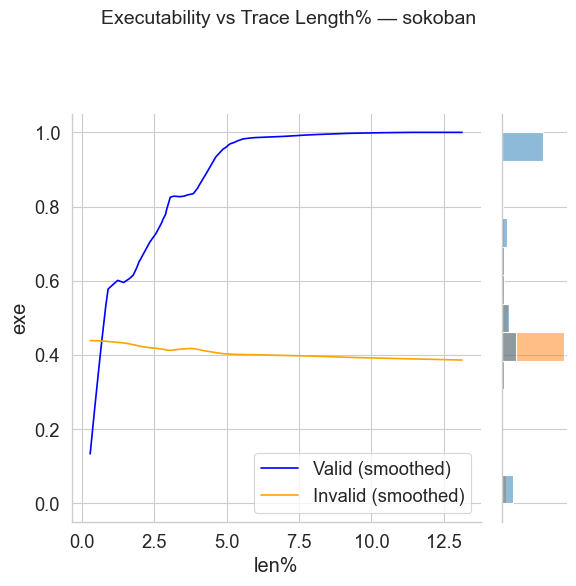

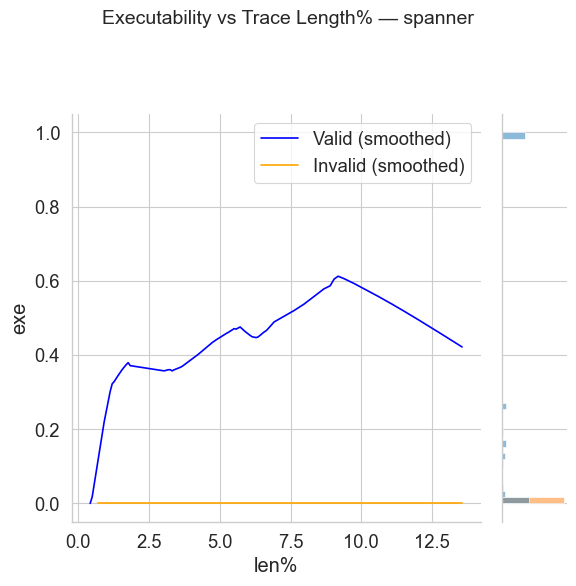

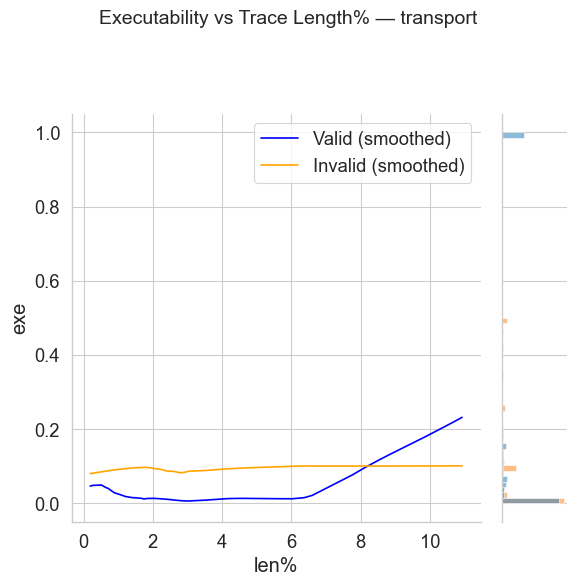

In [37]:


# Get unique domains
domains = df['domain'].unique()

for domain in domains:
    domain_df = df_by_len[df_by_len['domain'] == domain].copy()

    # Apply LOWESS smoothing
    valid_smoothed = lowess(domain_df['acceptance_rate'], domain_df['len%'], frac=0.3)
    filtered_df = domain_df[domain_df['acceptance_rate'] > 0.3]
    invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['len%'], frac=0.3)

    valid_smoothed[:, 1] = valid_smoothed[:, 1].clip(0, 1)
    invalid_smoothed[:, 1] = invalid_smoothed[:, 1].clip(0, 1)

    # Melt to long format for seaborn
    df_long = pd.melt(
        domain_df,
        id_vars=['len%'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Create jointplot
    g = sns.jointplot(
        data=df_long,
        x='len%', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False, stat='density')
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines
    g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], color='blue', label='Valid (smoothed)')
    g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], color='orange', label='Invalid (smoothed)')
    g.ax_joint.legend()

    # Add title
    g.fig.suptitle(f"Executability vs Trace Length% — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()


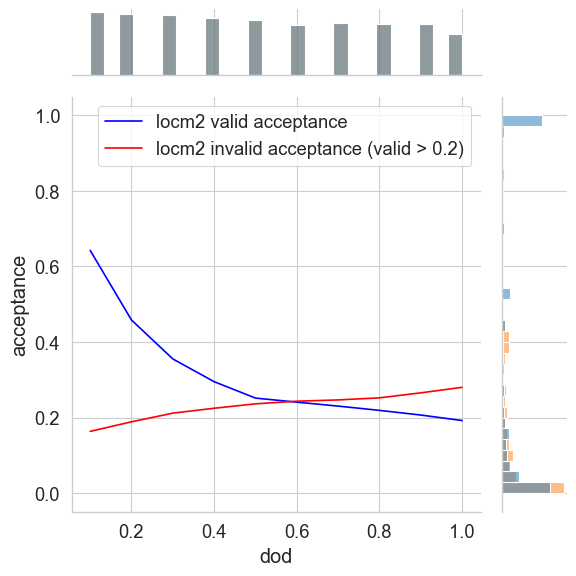

In [38]:
df_by_flex = df.sort_values(by='dod')

valid_smoothed = lowess(df_by_len['acceptance_rate'], df_by_len['dod'], frac=0.3)
filtered_df = df_by_len[df_by_len['acceptance_rate'] > 0.3]
invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['dod'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['dod'], value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
                  var_name='type', value_name='acceptance')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='dod', y='acceptance', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], label='locm2 valid acceptance', color='blue')
plt.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], label='locm2 invalid acceptance (valid > 0.2)', color='red')



plt.legend()
plt.tight_layout()
plt.show()

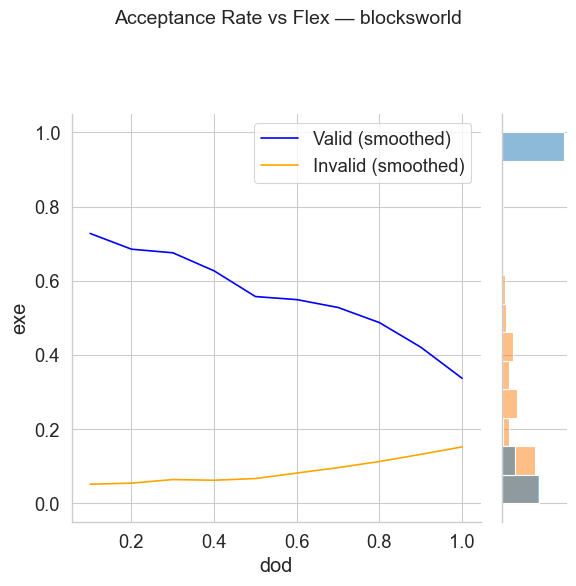

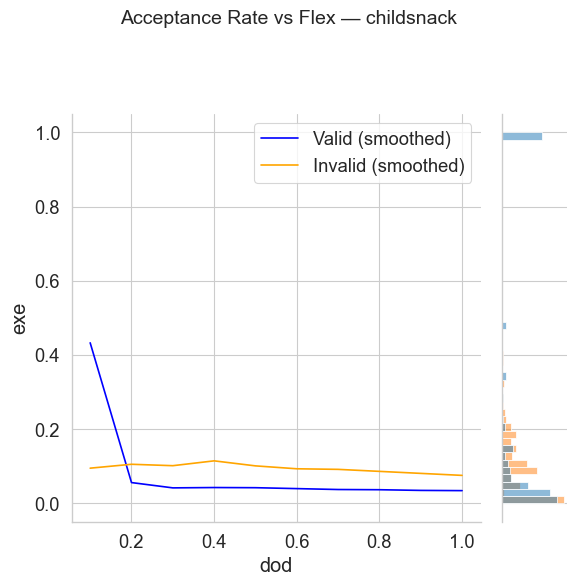

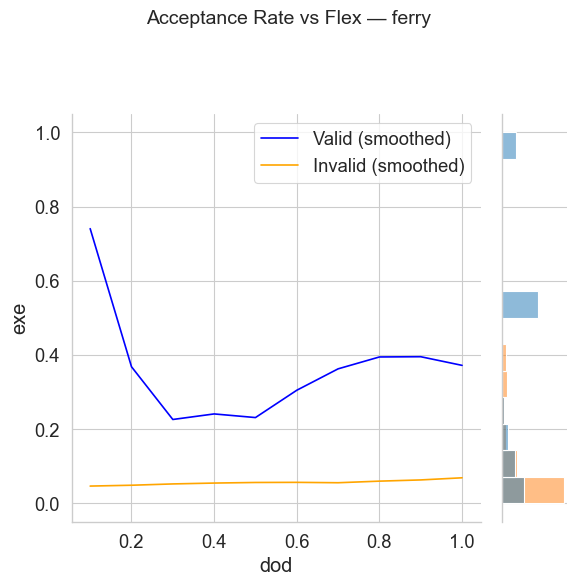

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


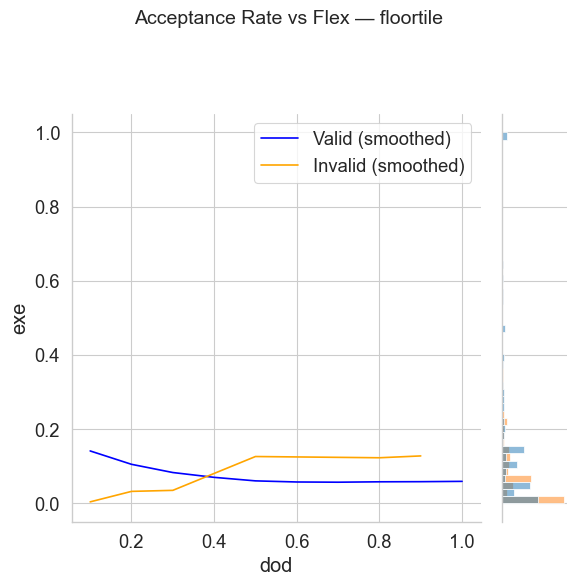

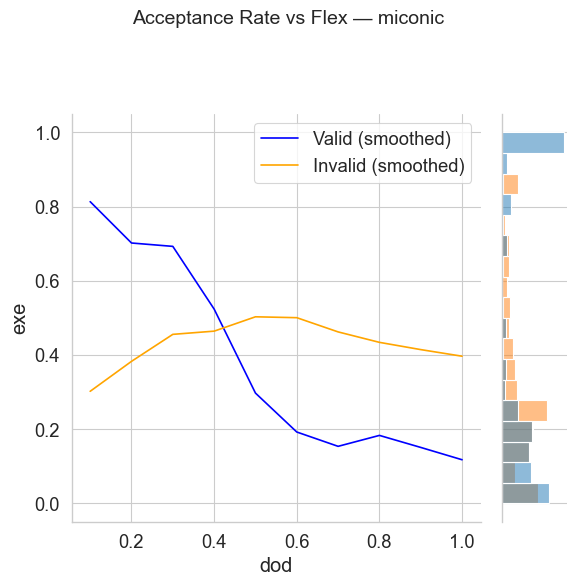

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


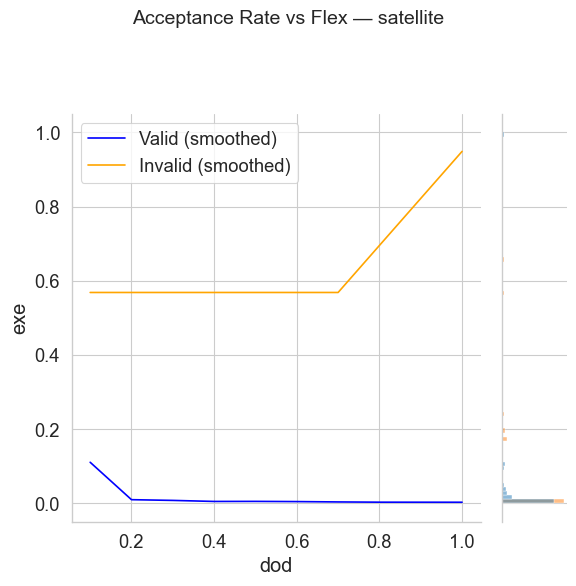

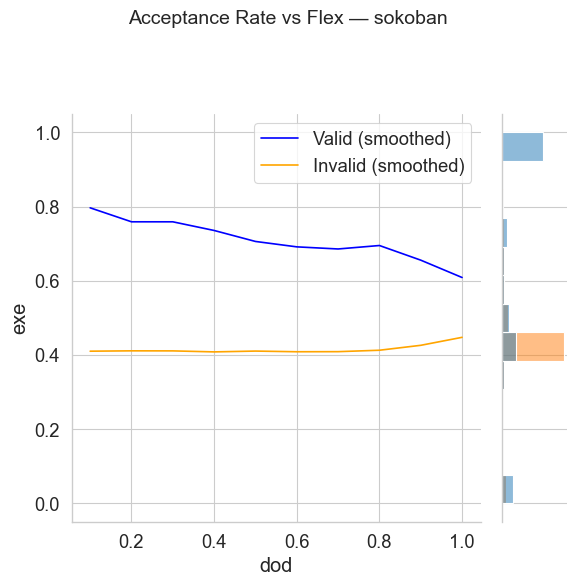

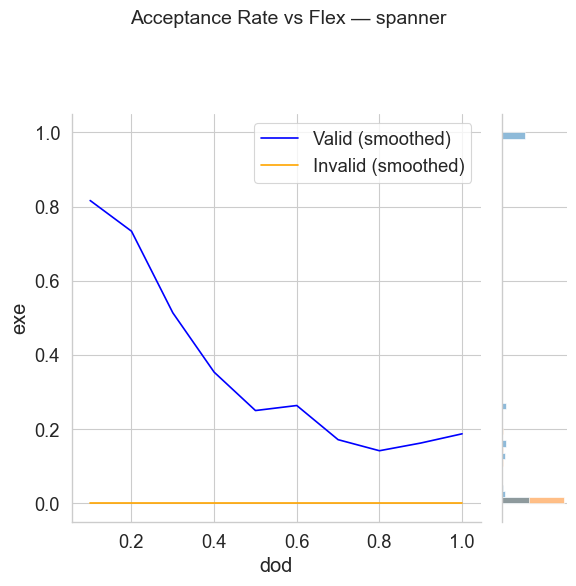

c:\Users\Apexmod\miniforge3\envs\llm\Lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


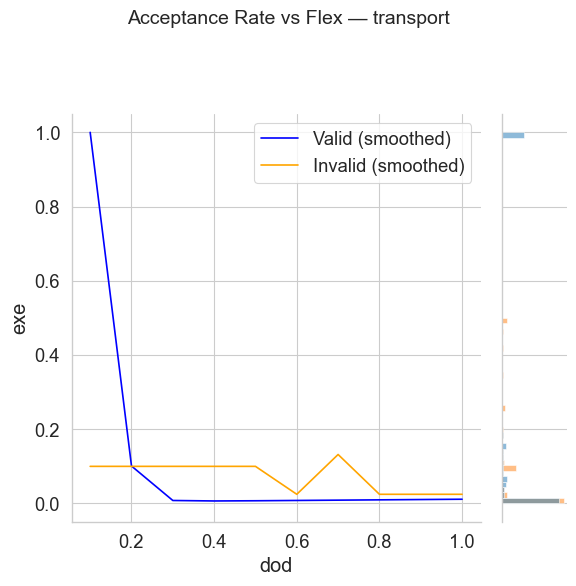

In [39]:

# Get unique domains
domains = df['domain'].unique()

for domain in domains:
    domain_df = df_by_flex[df_by_flex['domain'] == domain].copy()

    # Apply LOWESS smoothing
    valid_smoothed = lowess(domain_df['acceptance_rate'], domain_df['dod'], frac=0.3)
    filtered_df = domain_df[domain_df['acceptance_rate'] > 0.3]
    invalid_smoothed = lowess(filtered_df['invalid_acceptance_rate'], filtered_df['dod'], frac=0.3)

    valid_smoothed[:, 1] = valid_smoothed[:, 1].clip(0, 1)
    invalid_smoothed[:, 1] = invalid_smoothed[:, 1].clip(0, 1)

    # Melt to long format for seaborn
    df_long = pd.melt(
        domain_df,
        id_vars=['dod'],
        value_vars=['acceptance_rate', 'invalid_acceptance_rate'],
        var_name='type',
        value_name='exe'
    )

    # Create jointplot
    g = sns.jointplot(
        data=df_long,
        x='dod', y='exe', hue='type',
        kind='hist', alpha=0,
        height=6, marginal_kws=dict(common_norm=False)
    )
    g.ax_marg_x.set_visible(False)

    # Overlay LOWESS lines
    g.ax_joint.plot(valid_smoothed[:, 0], valid_smoothed[:, 1], color='blue', label='Valid (smoothed)')
    g.ax_joint.plot(invalid_smoothed[:, 0], invalid_smoothed[:, 1], color='orange', label='Invalid (smoothed)')
    g.ax_joint.legend()

    # Add title
    g.fig.suptitle(f"Acceptance Rate vs Flex — {domain}", fontsize=14)
    g.fig.tight_layout()
    g.fig.subplots_adjust(top=0.95)

    # Show the plot
    plt.show()


# Accuracy

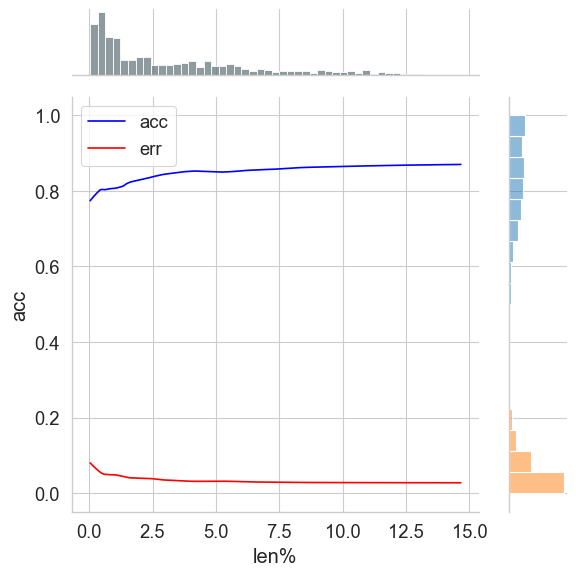

In [40]:

acc = lowess(df_by_len['accuracy'], df_by_len['len%'], frac=0.3)

err = lowess(df_by_len['error_rate'], df_by_len['len%'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_len, id_vars=['len%'], value_vars=['accuracy', 'error_rate'],
                  var_name='type', value_name='acc')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='len%', y='acc', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(acc[:, 0], acc[:, 1], label='acc', color='blue')
plt.plot(err[:, 0], err[:, 1], label='err', color='red')



plt.legend()
plt.tight_layout()
plt.show()

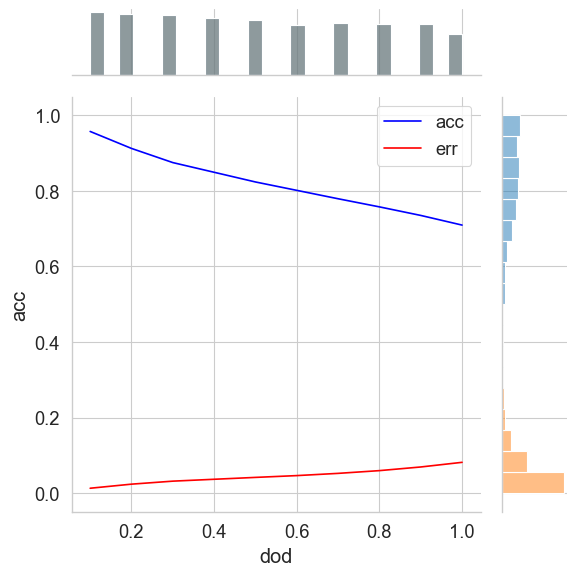

In [41]:


acc = lowess(df_by_flex['accuracy'], df_by_flex['dod'], frac=0.3)

err = lowess(df_by_len['error_rate'], df_by_len['dod'], frac=0.3)

# Combine into dataframe for seaborn
df_long_l2 = pd.melt(df_by_flex, id_vars=['dod'], value_vars=['accuracy', 'error_rate'],
                  var_name='type', value_name='acc')

# Plot using seaborn
g1 = sns.jointplot(
    data=df_long_l2, x='dod', y='acc', hue='type',
    kind='hist', alpha=0, height=6, marginal_kws=dict(common_norm=False)
)


plt.plot(acc[:, 0], acc[:, 1], label='acc', color='blue')
plt.plot(err[:, 0], err[:, 1], label='err', color='red')



plt.legend()
plt.tight_layout()
plt.show()

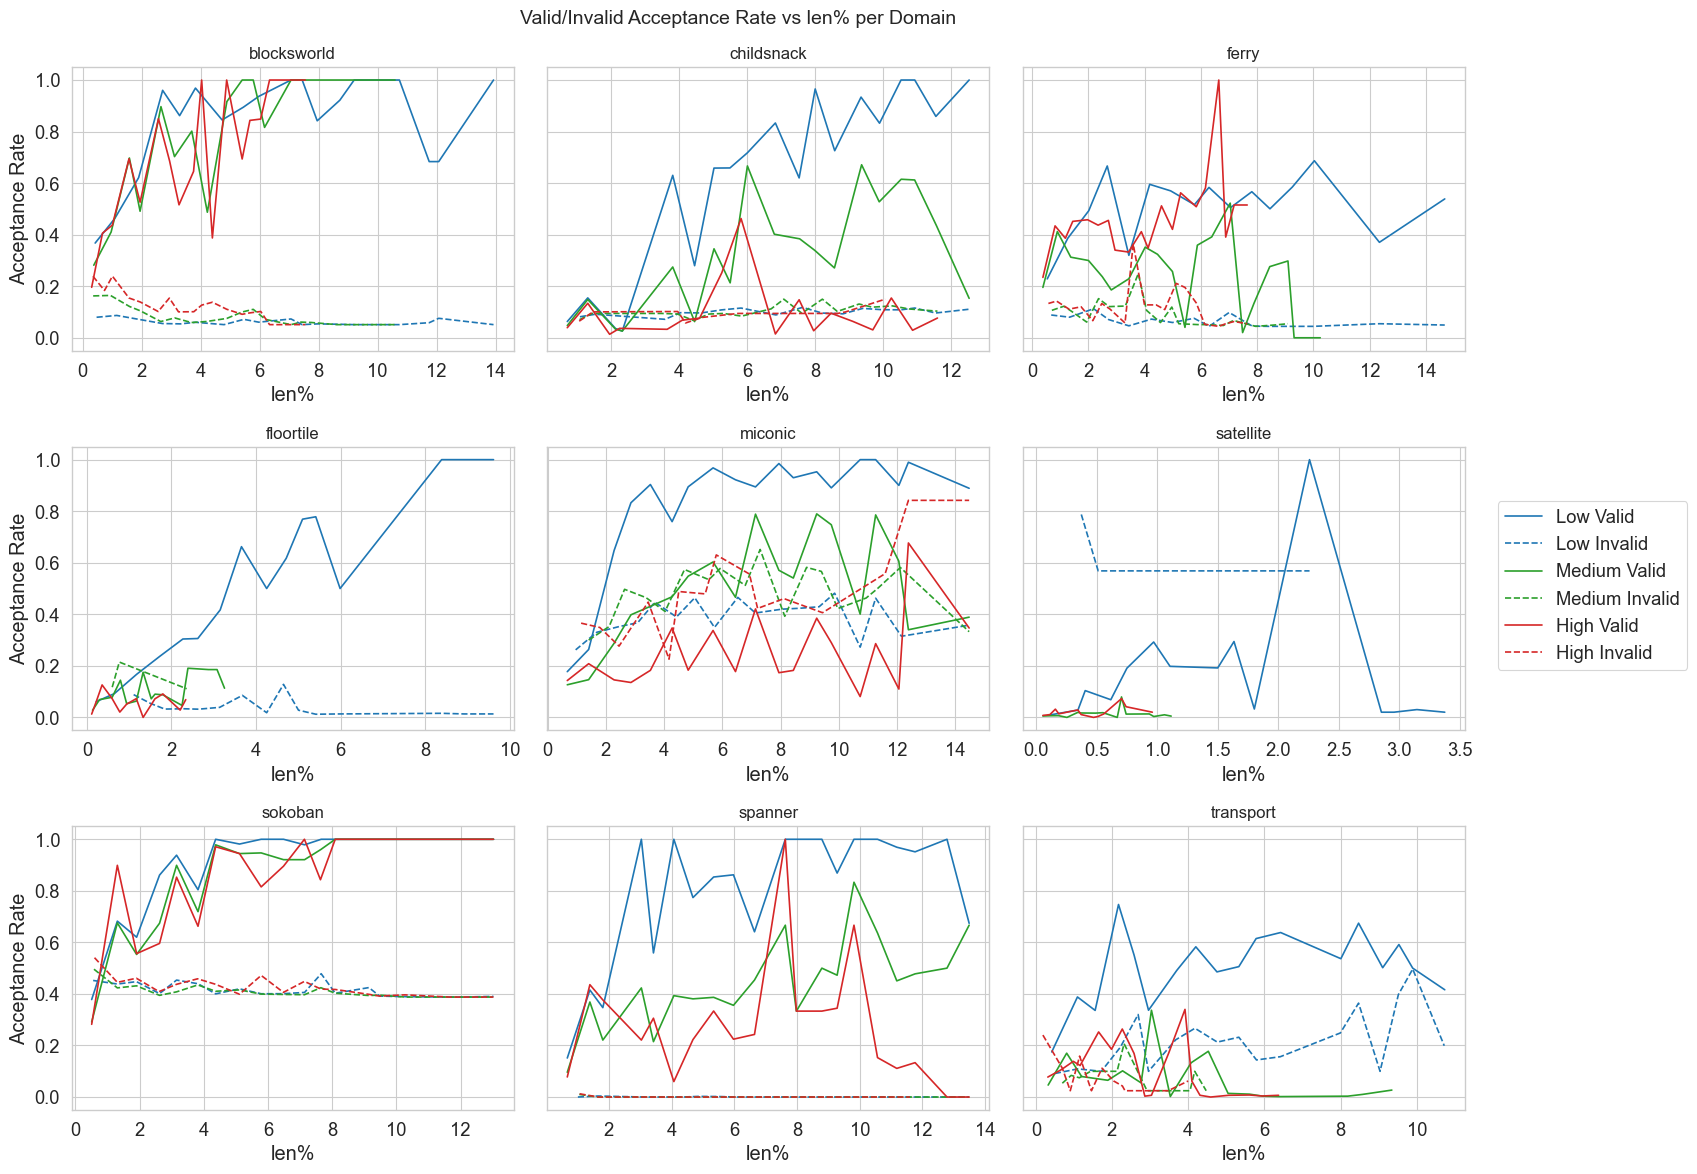

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# --- 1. classify flex levels ---------------------------------------------
def flex_level(dod):
    if 0.1 <= dod <= 0.3: return 'Low'
    if 0.4 <= dod <= 0.6: return 'Medium'
    if 0.7 <= dod <= 0.9: return 'High'
    return 'Other'

df['flex_level'] = df['dod'].apply(flex_level)
df['len%'] = pd.to_numeric(df['len%'], errors='coerce')
df['acceptance_rate'] = pd.to_numeric(df['acceptance_rate'], errors='coerce')

# --- 2. plotting parameters ----------------------------------------------
domains = sorted(df['domain'].unique())
colors = {'Low': 'tab:blue', 'Medium': 'tab:green', 'High': 'tab:red'}
n_cols = 3
n_rows = int(np.ceil(len(domains) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()

# --- 3. smoothing function: binned mean -----------------------------------
def smooth_by_binned_mean(sub_df, x_col, y_col, bins=20):
    sub_df = sub_df.copy()
    sub_df['len_bin'] = pd.cut(sub_df[x_col], bins=bins)
    grouped = sub_df.groupby('len_bin', observed=True).agg({
        x_col: 'mean',
        y_col: 'mean'
    }).dropna()
    return grouped[x_col].values, grouped[y_col].values

# --- 4. plot per domain --------------------------------------------------
for idx, domain in enumerate(domains):
    ax = axes[idx]
    sub = df[df['domain'] == domain]

    for flex in ['Low', 'Medium', 'High']:
        flex_df = sub[sub['flex_level'] == flex]
        if flex_df.empty:
            continue

        # Valid acceptance rate (solid)
        x_v, y_v = smooth_by_binned_mean(flex_df, 'len%', 'acceptance_rate')
        ax.plot(x_v, y_v, color=colors[flex], linestyle='-', label=f'{flex} Valid')

        # Invalid acceptance rate (dashed)
        x_iv, y_iv = smooth_by_binned_mean(flex_df[flex_df["acceptance_rate"]>0.3], 'len%', 'invalid_acceptance_rate')
        ax.plot(x_iv, y_iv, color=colors[flex], linestyle='--', label=f'{flex} Invalid')

    ax.set_title(domain, fontsize=12)
    ax.set_xlabel('len%')
    if idx % n_cols == 0:
        ax.set_ylabel('Acceptance Rate')
    ax.grid(True)

# Clean unused axes
for j in range(len(domains), len(axes)):
    fig.delaxes(axes[j])

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.suptitle('Valid/Invalid Acceptance Rate vs len% per Domain', fontsize=14)
plt.tight_layout()
plt.show()
